In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
np.random.seed(0)

NUM_NODES = 300
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80

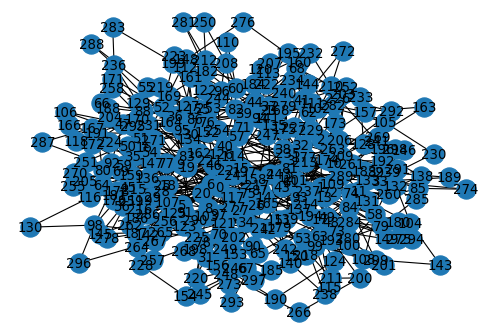

In [28]:
#g = nx.cycle_graph(NUM_NODES, nx.DiGraph)
#g = nx.grid_graph(dim=[5,4])
#g = nx.convert_node_labels_to_integers(g)
g = nx.barabasi_albert_graph(NUM_NODES, 2, seed=0)
#g = nx.bull_graph()
nx.draw(g, with_labels=True, pos=nx.spring_layout(g, seed=123))
#print(nx.to_numpy_matrix(g))

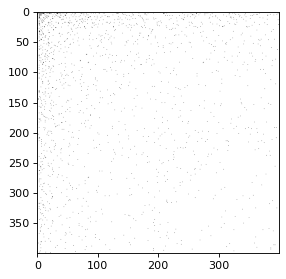

In [13]:
plt.imshow(nx.to_numpy_array(g), cmap='Greys')

In [29]:
#simulates voter dynamics for one step
def step_voter_dyn(state, graph):
    next_state = np.zeros_like(state)
    for i in range(len(state)):
        # determine number of "opinionated" neighbors of node i
        neighbors_iter = graph.predecessors(i) if nx.is_directed(graph) else graph.neighbors(i)
        num_op = sum(1 for pred in neighbors_iter if state[pred] == 1)
        #print('node ' + str(i) + ' num_op: ' + str(num_op))
        #print('degree ' + str(i) + ': ' + str(graph.in_degree[i]))
        # generate next state with P(1) = num_op/degree
        deg = graph.in_degree[i] if nx.is_directed(graph) else graph.degree[i]
        next_state[i] = 1 if np.random.uniform() < float(num_op)/float(deg) else 0
    return next_state

In [4]:
def step_voter_dyn_async(state, graph):
    transitions = nx.to_numpy_array(graph)
    transitions = transitions / np.sum(transitions, axis=0)
    indices = np.arange(graph.number_of_nodes())
    np.random.shuffle(indices)
    next_state = np.copy(state)
    for i in indices:
        #print(next_state)
        next_state[i] = np.random.choice(next_state, p=transitions[:, i])
    return next_state

In [163]:
print(step_voter_dyn_async(np.zeros(20), g))
#np.random.choice(np.arange(5), p=np.array([0.1,0.1,0.1,0.1,0.6]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
# for data generation, it was not the any(...) line
def gen_sequence_until_attractor(visited_states, graph):
    # get initial state
    cand = np.random.randint(2, size=NUM_NODES)
    #print(cand)
    #while any([np.array_equal(vs, cand) for vs in visited_states]):
    #    cand = np.random.randint(2, size=NUM_NODES)
    
    # calculate path until we reach an attractor
    just_visited = []
    #just_visited.append(cand)
    cur_state = cand
    just_visited.append(cand)
    for _ in range(int(1e10)):
        next_state = step_voter_dyn(cur_state, graph) #ATTENTION-------------------------
        #print(next_state)
        if len(just_visited)>0 and any([np.array_equal(next_state, jv) for jv in just_visited]): #np.array_equal(just_visited[-1], next_state):
            just_visited.append(next_state)
            break
        else:
            just_visited.append(next_state)
            cur_state = next_state
    return np.array(just_visited)

In [42]:
seq = gen_sequence_until_attractor([], g)
print(seq.shape)

(165, 300)


In [43]:
def expand_sequence(seq):
     return np.array( [seq[0], *[val for val in seq[1:-1] for _ in (0, 1)], seq[-1]] )

In [44]:
# n is the amount of samples to generate (length will be 2*n because both input and predictions are contained in data)
def generate_dataset(n, graph):
    data = np.zeros((1,NUM_NODES), dtype = int)
    while data.shape[0] < 2*n+1:
        #print('restarting')
        new_seq = gen_sequence_until_attractor(data, graph)
        #new_data = new_seq
        new_data = expand_sequence(new_seq)
        #if new_data.shape[0]>5:
        data = np.concatenate((data, new_data), axis=0)
    return np.array(data[1:2*n+1,:])

In [46]:
def generate_dataset_output_raw_timeseries(n, graph):
    data = np.zeros((1,NUM_NODES), dtype = int)
    data_raw = np.zeros((1,NUM_NODES), dtype = int)
    while data.shape[0] < 2*n+1:
        #print('restarting')
        new_seq = gen_sequence_until_attractor(data, graph)
        #new_data = new_seq
        new_data = expand_sequence(new_seq)
        #if new_data.shape[0]>5:
        data = np.concatenate((data, new_data), axis=0)
        data_raw = np.concatenate((data_raw, new_seq), axis=0)
    return np.array(data_raw[1:n+1,:])

In [47]:
np.random.seed(0)
ds = generate_dataset(1000, g)
np.random.seed(0)
ds_raw = generate_dataset_output_raw_timeseries(1000, g)
print(ds.shape)
print(ds_raw.shape)
print(ds[0:40,:])
print(ds_raw[0:40,:])

(2000, 300)
(1000, 300)
[[0 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 ...
 [1 1 0 ... 1 0 1]
 [1 1 0 ... 1 0 1]
 [1 1 0 ... 1 1 1]]
[[0 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 0]
 [0 1 1 ... 0 1 1]
 ...
 [0 0 1 ... 0 1 1]
 [1 1 0 ... 0 1 1]
 [1 1 1 ... 0 0 1]]


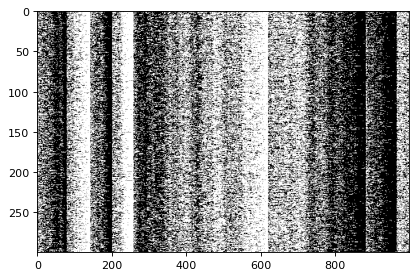

In [48]:
plt.imshow(ds_raw.transpose()[:,0:1000], cmap='Greys', aspect='auto')

In [49]:
file = open(r'D:\Uni\BA\Development\data\final\Voter\timeseries_ba300_1k.pickle', 'wb')
pickle.dump(ds, file)
file.close()
print('done')

done


In [71]:
#print(nx.to_numpy_matrix(g).astype(int))

In [50]:
#file = open(r'D:\Uni\BA\Development\data\final\Voter\timeseries_ba20_100.pickle', 'wb')
#pickle.dump(ds, file)
#file.close()
file = open(r'D:\Uni\BA\Development\data\final\edges_ba300.pickle', 'wb')
pickle.dump(nx.to_numpy_matrix(g).astype(int), file)
file.close()

### Visualization

(200, 5)


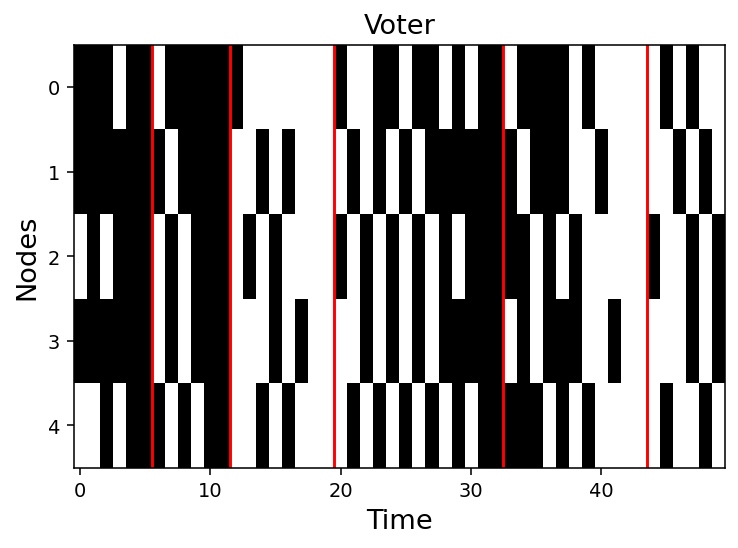

In [207]:
#ds = generate_dataset(100, g)
print(ds.shape)
TS=ds.transpose()
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=140)#gridspec_kw={'width_ratios':[1,1,2.15]},dpi=200)

ax.imshow(TS[:,0:50], cmap='Greys', aspect='auto', interpolation='none')
#ax.set_yticks([])
ax.set_xlabel("Time", size=14)
ax.set_ylabel("Nodes", size=14)
ax.set_title("Voter", size=14)

linest = 'solid'
col='red'
plt.plot([5.5,5.5], [-0.5, 4.5], color=col, linestyle=linest)
plt.plot([11.5,11.5], [-0.5, 4.5], color=col, linestyle=linest)
plt.plot([19.5,19.5], [-0.5, 4.5], color=col, linestyle=linest)
plt.plot([32.5,32.5], [-0.5, 4.5], color=col, linestyle=linest)
plt.plot([43.5,43.5], [-0.5, 4.5], color=col, linestyle=linest)
plt.show()

In [208]:
fig.savefig(r"D:\Uni\BA\notebooks\netrd_notebooks\timeseries_plots\voter.png", dpi=140,pad_inches=0)